# Partie 1 : Préparation des Données

In [25]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

#importation du simpleLime Class 
from lime_implementation import SimpleLIME

 #Option 1 : California Housing (recommande)
data = fetch_california_housing()
 # Charger les donnees
X = data.data
y = data.target
feature_names = data.feature_names
print(feature_names)

  # Separer en train/test
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42
  )


n_features = X.shape[1]
print("nbr de featur est",  n_features)
y = data.target
target_name = data.target_names[0]
print(target_name)
print(y)

print(X_test.shape[0])  # nombre de lignes (échantillons)
print(y_test.shape[0])



['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
nbr de featur est 8
MedHouseVal
[4.526 3.585 3.521 ... 0.923 0.847 0.894]
4128
4128


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=17, random_state=42)
# Entrainer le modele

model.fit(X_train, y_train)
 # Evaluer sur le test (MSE et R2)
 #  Prédire sur le jeu de test
y_pred = model.predict(X_test)

#  Calculer le MSE : compare le vrai y (y_test) et le y prédit (y_pred) et calcule l’erreur moyenne entre les deux.
mse = mean_squared_error(y_test, y_pred)

#  Calculer le R²
r2 = r2_score(y_test, y_pred)

print("MSE :", mse)
print("R² :", r2)


MSE : 0.2679197680430621
R² : 0.7955449233851258


# Partie 3 : Expérimentation

In [27]:
# Créer l'explainer
explainer = SimpleLIME(
    X_train,
    feature_names=feature_names,
    kernel_width=1.0,
    n_samples=5000
)

# Choisir une instance à expliquer
instance_idx = 0
x_star = X_test[instance_idx]

# Générer l'explication
explanation = explainer.explain_instance(
    x_star,
    model.predict,
    num_features=len(feature_names)
)

# Afficher les résultats
print(f"Instance : {x_star}")
print(f"Prédiction du modèle : {model.predict([x_star])[0]:.2f}")
print(f"Valeur réelle : {y_test[instance_idx]:.2f}")

print("\nImportances des features :")
for feature, coef in explanation['coefficients'].items():
    print(f"  {feature}: {coef:.4f}")

print(f"\nFidélité locale (R^2) : {explanation['r2_score']:.4f}")


Instance : [ 1.68120000e+00  2.50000000e+01  4.19220056e+00  1.02228412e+00
  1.39200000e+03  3.87743733e+00  3.60600000e+01 -1.19010000e+02]
Prédiction du modèle : 0.49
Valeur réelle : 0.48

Importances des features :
  MedInc: 0.1189
  AveRooms: 0.0703
  AveOccup: -0.0430
  Latitude: -0.0308
  Population: 0.0112
  HouseAge: 0.0055
  AveBedrms: -0.0010
  Longitude: -0.0006

Fidélité locale (R^2) : 0.3305


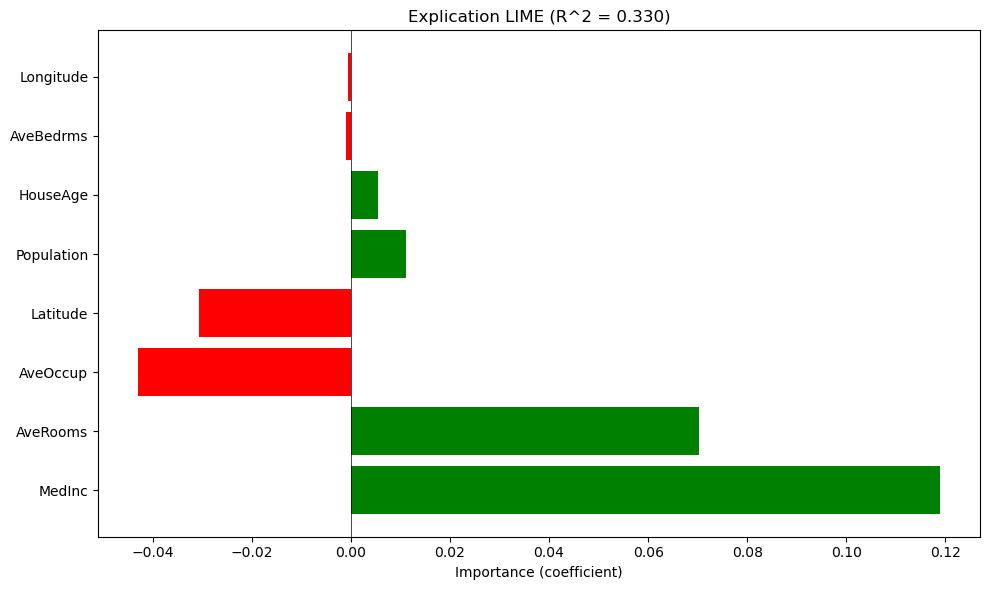

In [28]:
import matplotlib.pyplot as plt

def plot_explanation(explanation):

    features = list(explanation['coefficients'].keys())
    importances = list(explanation['coefficients'].values())
    colors = ['green' if x > 0 else 'red' for x in importances]

    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color=colors)
    plt.xlabel('Importance (coefficient)')
    plt.title(
        f"Explication LIME (R^2 = {explanation['r2_score']:.3f})"
    )
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()


plot_explanation(explanation)


# Partie 4 : Analyse de Sensibilité

In [29]:
#Impact du paramètre σ (kernel_width)
sigmas = [0.25, 0.5, 1.0, 2.0]

for sigma in sigmas:
    explainer = SimpleLIME(X_train, feature_names, kernel_width=sigma)
    exp = explainer.explain_instance(x_star, model.predict)
    print(f"\nsigma = {sigma}")
    print(f"R^2 = {exp['r2_score']:.3f}")
    print(f"Top feature: {list(exp['coefficients'].items())[0]}")


sigma = 0.25
R^2 = 1.000
Top feature: ('MedInc', np.float64(0.00017699288228038997))

sigma = 0.5
R^2 = 0.718
Top feature: ('MedInc', np.float64(0.04217293428731155))

sigma = 1.0
R^2 = 0.487
Top feature: ('MedInc', np.float64(0.11087490016102983))

sigma = 2.0
R^2 = 0.368
Top feature: ('MedInc', np.float64(0.07665162694530696))


In [30]:
pip install lime 

Note: you may need to restart the kernel to use updated packages.


# Partie 5 : Comparaison avec LIME Officiel

In [31]:

from lime import lime_tabular

# Créer l’explainer officiel
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    mode='regression',
    kernel_width=1.0,
    discretize_continuous=False
)

# Expliquer la même instance avec LIME officiel
lime_explanation = lime_explainer.explain_instance(
    x_star,
    model.predict,
    num_features=len(feature_names),
    num_samples=5000
)

# Afficher les résultats
print("=== LIME Officiel ===")
print(f"R^2 score: {lime_explanation.score:.4f}")

print("\nImportances des features:")
for feature, coef in lime_explanation.as_list():
    print(f"  {feature}: {coef:.4f}")


=== LIME Officiel ===
R^2 score: 0.5037

Importances des features:
  MedInc: 0.5767
  AveOccup: -0.5542
  Latitude: -0.3968
  Longitude: -0.2790
  HouseAge: 0.1045
  AveBedrms: 0.0251
  Population: 0.0221
  AveRooms: -0.0200


# Comparaison des résultats

In [32]:
import pandas as pd

your_coeffs = dict(explanation['coefficients'])

# LIME officiel
lime_coeffs = dict(lime_explanation.as_list())

# Créer un tableau comparatif
comparison = pd.DataFrame({
    'Votre LIME': your_coeffs,
    'LIME Officiel': lime_coeffs
})

comparison['Difference'] = abs(
    comparison['Votre LIME'] - comparison['LIME Officiel']
)

comparison = comparison.sort_values(
    'Difference',
    ascending=False
)

print("\n=== Comparaison ===")
print(comparison)

print(f"\nVotre R^2: {explanation['r2_score']:.4f}")
print(f"LIME Officiel R^2: {lime_explanation.score:.4f}")
print(
    f"Difference R^2: "
    f"{abs(explanation['r2_score'] - lime_explanation.score):.4f}"
)



=== Comparaison ===
            Votre LIME  LIME Officiel  Difference
AveOccup     -0.042963      -0.554215    0.511252
MedInc        0.118922       0.576679    0.457757
Latitude     -0.030774      -0.396807    0.366033
Longitude    -0.000562      -0.279028    0.278466
HouseAge      0.005529       0.104451    0.098921
AveRooms      0.070290      -0.020039    0.090329
AveBedrms    -0.001002       0.025141    0.026143
Population    0.011178       0.022149    0.010971

Votre R^2: 0.3305
LIME Officiel R^2: 0.5037
Difference R^2: 0.1732


In [33]:
#explainer 2 avec kernel_width =2.0 et n_samples=50000
# Créer l'explainer
explainer2 = SimpleLIME(
    X_train,
    feature_names=feature_names,
    kernel_width=2.0,
    n_samples=50000
)

# Choisir une instance à expliquer
instance_idx = 0
x_star = X_test[instance_idx]

# Générer l'explication
explanation = explainer2.explain_instance(
    x_star,
    model.predict,
    num_features=len(feature_names)
)

# Afficher les résultats
print(f"Instance : {x_star}")
print(f"Prédiction du modèle : {model.predict([x_star])[0]:.2f}")
print(f"Valeur réelle : {y_test[instance_idx]:.2f}")

print("\nImportances des features :")
for feature, coef in explanation['coefficients'].items():
    print(f"  {feature}: {coef:.4f}")

print(f"\nFidélité locale (R^2) : {explanation['r2_score']:.4f}")

Instance : [ 1.68120000e+00  2.50000000e+01  4.19220056e+00  1.02228412e+00
  1.39200000e+03  3.87743733e+00  3.60600000e+01 -1.19010000e+02]
Prédiction du modèle : 0.49
Valeur réelle : 0.48

Importances des features :
  MedInc: 0.0763
  AveOccup: -0.0740
  AveBedrms: -0.0502
  AveRooms: 0.0384
  Longitude: 0.0094
  Latitude: 0.0066
  Population: -0.0008
  HouseAge: 0.0004

Fidélité locale (R^2) : 0.4358


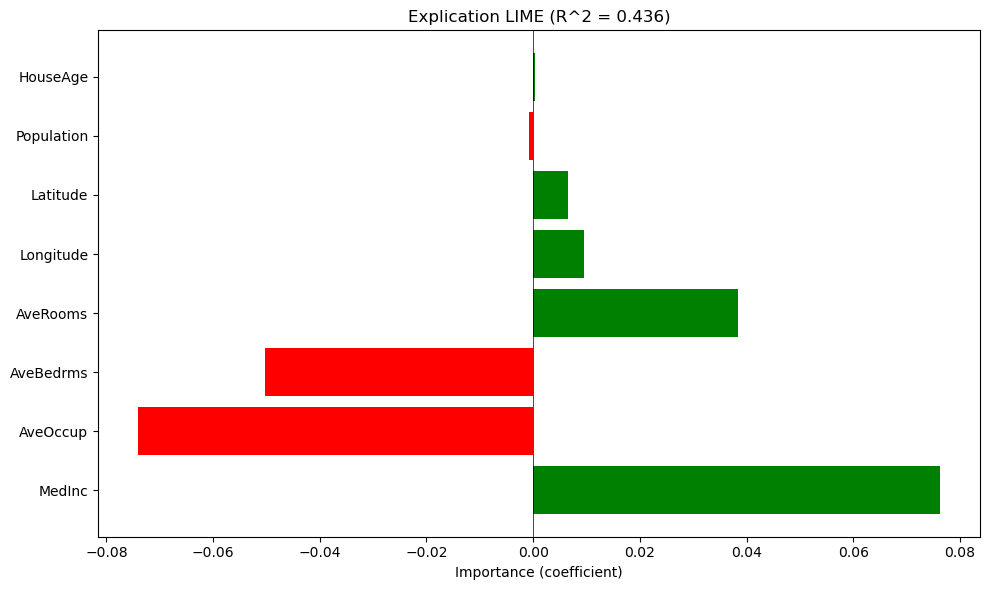

In [34]:
#visualization explainer 2 
import matplotlib.pyplot as plt

def plot_explanation(explanation):

    features = list(explanation['coefficients'].keys())
    importances = list(explanation['coefficients'].values())
    colors = ['green' if x > 0 else 'red' for x in importances]

    plt.figure(figsize=(10, 6))
    plt.barh(features, importances, color=colors)
    plt.xlabel('Importance (coefficient)')
    plt.title(
        f"Explication LIME (R^2 = {explanation['r2_score']:.3f})"
    )
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()


plot_explanation(explanation)


In [35]:
# comparaison 

import pandas as pd

your_coeffs = dict(explanation['coefficients'])

# LIME officiel
lime_coeffs = dict(lime_explanation.as_list())

# Créer un tableau comparatif
comparison = pd.DataFrame({
    'Votre LIME': your_coeffs,
    'LIME Officiel': lime_coeffs
})

comparison['Difference'] = abs(
    comparison['Votre LIME'] - comparison['LIME Officiel']
)

comparison = comparison.sort_values(
    'Difference',
    ascending=False
)

print("\n=== Comparaison ===")
print(comparison)

print(f"\nVotre R^2: {explanation['r2_score']:.4f}")
print(f"LIME Officiel R^2: {lime_explanation.score:.4f}")
print(
    f"Difference R^2: "
    f"{abs(explanation['r2_score'] - lime_explanation.score):.4f}"
)



=== Comparaison ===
            Votre LIME  LIME Officiel  Difference
MedInc        0.076255       0.576679    0.500424
AveOccup     -0.074015      -0.554215    0.480200
Latitude      0.006590      -0.396807    0.403397
Longitude     0.009450      -0.279028    0.288477
HouseAge      0.000366       0.104451    0.104085
AveBedrms    -0.050194       0.025141    0.075335
AveRooms      0.038405      -0.020039    0.058444
Population   -0.000781       0.022149    0.022930

Votre R^2: 0.4358
LIME Officiel R^2: 0.5037
Difference R^2: 0.0678
